In [1]:
import jax.numpy as jnp
import jax.random as jrd

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

sdgplt.FIGSIZE = 4

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Mixed Effects Model Specification

First, let's define the model with the abstract object AbstractMixedEffectsModel. We want to define the following logisitc models :

$$ \left\{\begin{array}{rll}
            Y_{i,j} &= m(t_{i,j}; \varphi_i) + \varepsilon_{i,j}
            \\ \varphi_i \sim \mathcal N(\mu, \Gamma)
            & ; ~\varepsilon_{i,j} \sim \mathcal N(0,\sigma^2=5e^{-3}).             
        \end{array}\right. ~ \forall i \in\{1,...,N\}, j\in\{1,...,J\}$$

where $\mu = (0.8,0.6), \Gamma^2=diag([5e^{-3},5e^{-3}])$, and : $$m(t_{i,j}; \varphi_i) = \frac{\varphi_{1,i}}{1+\exp\left(\frac{\varphi_{2,i}+\beta^T X_i-t_{i,j}}{\tau} \right)}$$

with $X_i \sim \mathcal U([-1e^{-2},1e^{-2}]), \forall i \in \{1, ..., N\}$ and $\tau = 5e^{-2}$, $\beta = [-15,-5,10,20,...]$

In [2]:
def m(params, times, phi1, phi2, cov, **kwargs) -> jnp.ndarray:
    ksi = cov @ params.beta + phi2
    out = phi1[:, None] / (1 + jnp.exp(-(times - ksi[:, None]) / params.tau))
    assert out.shape == times.shape
    return out

In [3]:
import functools
from jax import jit

from sdg4varselect.models import AbstractMixedEffectsModel, AbstractHDModel


class LogisticMixedEffectsModel(AbstractMixedEffectsModel, AbstractHDModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, P=1, **kwargs):
        AbstractHDModel.__init__(self, P=P)
        AbstractMixedEffectsModel.__init__(self, N=N, J=J, **kwargs)
        self.add_latent_variables("phi1")
        self.add_latent_variables("phi2")

    @property
    def name(self):
        return f"NLMEM{self.N}_J{self.J}_P{self.P}"

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.Real(
                shape=(2,), scale=(10, 10), loc=jnp.array([0, 1000])
            ),  # 0.1),
            cov_latent=pc.MatrixDiagPosDef(dim=2, scale=(1, 10)),  # 0.1),
            tau=pc.Real(scale=1, loc=100),
            var_residual=pc.RealPositive(scale=1),
            beta=pc.Real(scale=1, shape=(self.P,)),
        )
        self.parametrization_size = self._parametrization.size

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):
        (prngkey_mem, prngkey_cov) = jrd.split(prngkey, num=2)

        # === nlmem_simulation() === #
        # time = 10*jnp.linspace(0.01, 1, self.J)
        time = jnp.linspace(150, 3000, self.J)
        time = jnp.tile(time, (self.N, 1))

        # cov = 5*3e-2 * jrd.uniform(prngkey_cov, minval=-1, maxval=1, shape=(self.N, self.P))
        cov = jrd.uniform(prngkey_cov, minval=-1, maxval=1, shape=(self.N, self.P))

        obs, sim = AbstractMixedEffectsModel.sample(
            self, params_star, prngkey_mem, mem_obs_time=time, cov=cov
        )

        return {"mem_obs_time": time, "cov": cov} | obs, sim

In [4]:
def plot_estimation(results, P=10):
    p_names = (
        [f"$\\mu_{{{i+1}}}$" for i in range(2)]
        + [f"$\\gamma^2_{{{1+i//2},{1+i%2}}}$" for i in range(2**2)]
        + ["$\\tau$", "$\\sigma^2$"]
        + [f"$\\beta_{{{1+i}}}$" for i in range(P)]
    )
    fig = sdgplt.figure(8, 8)
    figs = sdgplt.plot_theta(
        results,
        fig=fig.subfigures(1, 2, wspace=0.07),
        params_names=p_names,
        id_to_plot=[
            [0, 1, 2, 5, 6, 7],
            [8 + i for i in range(P)],
        ],
    )

    for ax in figs[0].axes:
        ax.legend(loc="center right")
    for ax in figs[1].axes:
        ax.legend(loc="center left")

    figs[0].axes[0].set_title("Low Dimension")
    figs[1].axes[0].set_title("High Dimension")

In [5]:
from copy import deepcopy
from sdg4varselect.outputs import MultiGDResults
from sdg4varselect.algo import StochasticProximalGradientDescentPrecond as SPGD
import sdg4varselect.algo.preconditioner as preconditioner

FIM = preconditioner.Fisher()
algo = SPGD(FIM, lbd=800, save_all=False)
algo._preconditioned_lbd = False

algo.step_size.heating.step = 4000
algo.max_iter = 5000


def one_estim(prngkey, model, data, lbd):
    prngkey_theta, prngkey = jrd.split(prngkey)
    theta0 = jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
    algo.set_seed(prngkey)
    algo.lbd = lbd
    return algo.fit(model, data, theta0)


def selection_estim(prngkey, model, data, lbd):
    prngkey_selection, prngkey_estimation = jrd.split(prngkey)
    selection = one_estim(prngkey_selection, model, data, lbd)

    supp = (selection.last_theta != 0).at[: -model.P].set(True)
    dt = deepcopy(data)
    dt["cov"] = dt["cov"][:, supp[-model.P :]]

    model_shrink = deepcopy(model)
    model_shrink.P = supp[-model.P :].sum()
    model_shrink.init()
    estimation = one_estim(prngkey_estimation, model=model_shrink, data=dt, lbd=None)

    row, _ = estimation.theta.shape
    theta_expand = jnp.zeros(shape=(row, supp.shape[0]))
    estimation.theta = theta_expand.at[:, jnp.where(supp)[0]].set(estimation.theta)

    estimation.chrono += selection.chrono
    return estimation

## Simulation

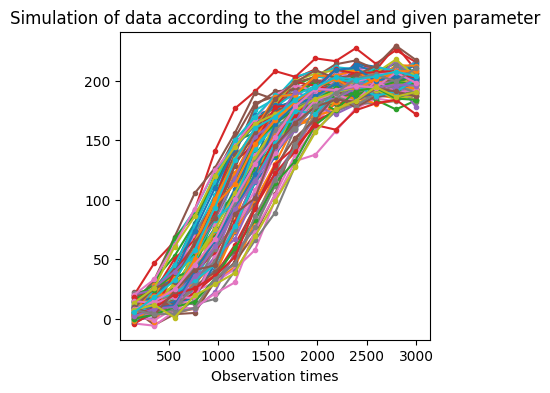

In [6]:
myModel = LogisticMixedEffectsModel(N=40*2, J=15, P=10)
algo.init_mcmc(myModel, adaptative_sd=False, sd={"phi1": 5, "phi2": 20})

# p_star = myModel.new_params(
#     mean_latent=jnp.array([0.8, 10 * 0.5]),
#     cov_latent=jnp.diag(jnp.array([5e-3, 10 * 2 * 5e-3])),
#     var_residual=5e-3,
#     tau=10 * 0.05,
#     beta=jnp.concatenate(  # [jnp.zeros(shape = (myModel.P,))]
#         [jnp.array([-15, -5, 10, 20]), jnp.zeros(shape=(myModel.P - 4,))]
#     ),
# )

p_star = myModel.new_params(
    mean_latent=jnp.array([200, 1200]),
    cov_latent=jnp.diag(jnp.array([50, 500])),
    tau=300,
    var_residual=30,
    beta=jnp.concatenate(
        # [jnp.zeros(shape=(myModel.P,))]
        [jnp.array([300, 100, -200]), jnp.zeros(shape=(myModel.P - 3,))]
    ),
)

# p_star = myModel.parametrization.reals1d_to_params(res.theta_reals1d[-1])
myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))

ax = sdgplt.ax(4, 4)
_ = ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, ".-")
_ = ax.set_title("Simulation of data according to the model and given parameter")
_ = ax.set_xlabel("Observation times")

## Estimation when the support is known

0:01:26.114501
../work/finish_simu_prox/NLMEM40_J15_P3_iteration SAVED !


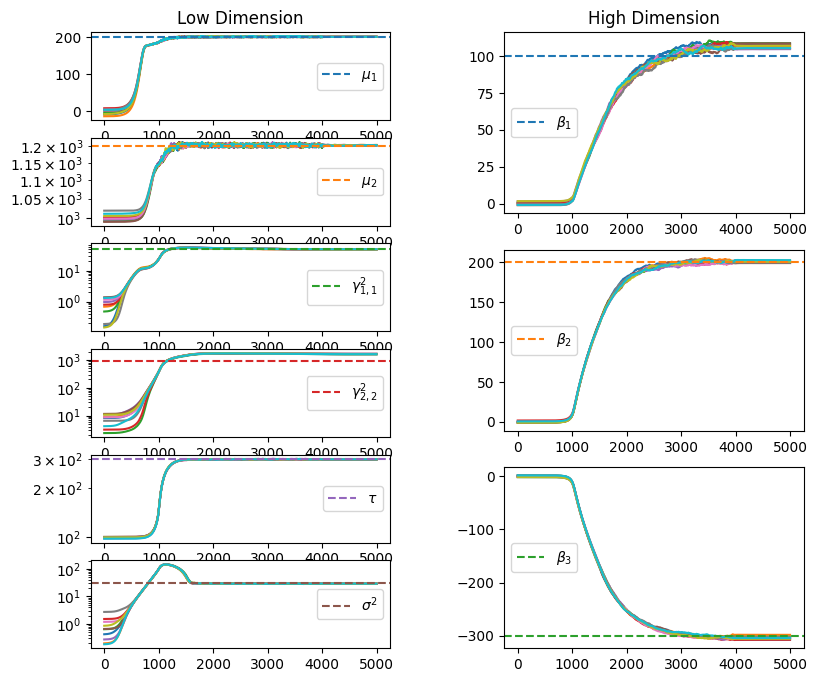

In [7]:
myModel_star = LogisticMixedEffectsModel(N=40, J=15, P=3)

p_star = myModel_star.new_params(
    mean_latent=jnp.array([200, 1200]),
    cov_latent=jnp.diag(jnp.array([7**2, 30**2])),
    tau=300,
    var_residual=30,
    beta=jnp.concatenate(
        [jnp.array([100, 200, -300]), jnp.zeros(shape=(myModel_star.P - 3,))]
    ),
)

myobs, mysim = myModel_star.sample(p_star, jrd.PRNGKey(0))

algorithm = SPGD(preconditioner.Fisher(), save_all=True)
algorithm.init_mcmc(myModel_star, adaptative_sd=False, sd={"phi1": 5, "phi2": 20})
algorithm._preconditioned_lbd = True
algorithm.step_size.heating.step = 4000

res = MultiGDResults(
    results=[
        algorithm.fit(
            myModel_star,
            myobs,
            jrd.normal(jrd.PRNGKey(i), shape=(myModel_star.parametrization.size,)),
        )
        for i in range(10)
    ]
)
res.theta_star = p_star

print(res.chrono)
plot_estimation(res, 3)
res.save(myModel_star, root="../work/finish_simu_prox", filename_add_on="iteration")

## Selection

In [342]:
from sdg4varselect._regularization_function import regularization_path


### Proximal Operator

In [ ]:
algo.save_all = False
lbd_set = 10 ** jnp.linspace(-2.0, -0.5, num=10)
algo._preconditioned_lbd = False
multi_estim = regularization_path(
    selection_estim,
    jrd.PRNGKey(0),
    lbd_set,
    model=myModel,
    data=myobs,
)

0:01:34.694258


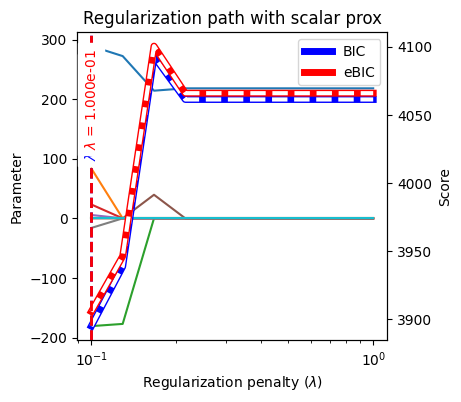

In [ ]:
fig = sdgplt.plot_regpath(multi_estim.standardize(), P=myModel.P)
fig.axes[0].set_title("Regularization path with scalar prox")
fig.axes[1].legend(loc="best")
print(multi_estim.chrono)

### Weigthed Proximal Operator

In [361]:
lbd_set = 10 ** jnp.linspace(0, 1, num=10)
algo._preconditioned_lbd = True
multi_estim_w = regularization_path(
    one_estim,  # selection_estim,
    jrd.PRNGKey(0),
    lbd_set,
    model=myModel,
    data=myobs,
)

0:00:50.568013


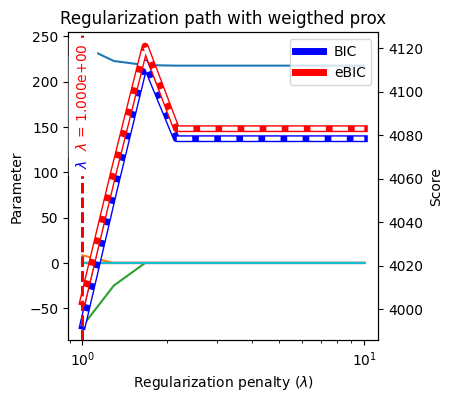

In [362]:
fig = sdgplt.plot_regpath(multi_estim_w.standardize(), P=myModel.P)
fig.axes[0].set_title("Regularization path with weigthed prox")
fig.axes[1].legend(loc="best")
print(multi_estim_w.chrono)

## Estimation


In [15]:
algo._preconditioned_lbd = True
algo._save_all = True
res = MultiGDResults(
    results=[one_estim(jrd.PRNGKey(i), myModel, data=myobs, lbd=0.8) for i in range(1)]
)
print(res.chrono)

0:00:12.521363


Text(0.5, 1.0, 'High Dimension')

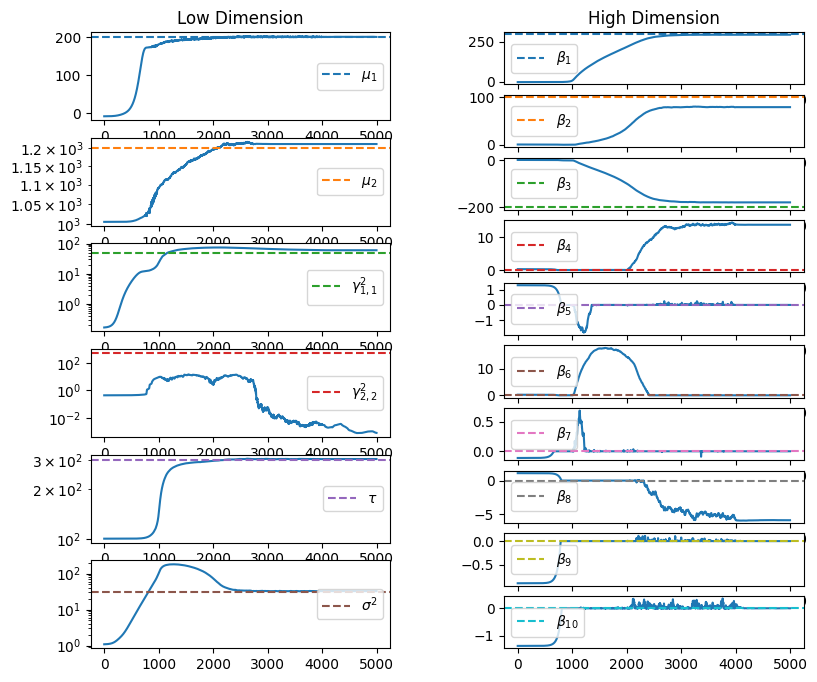

In [16]:
p_names = (
    [f"$\\mu_{{{i+1}}}$" for i in range(2)]
    + [f"$\\gamma^2_{{{1+i//2},{1+i%2}}}$" for i in range(2**2)]
    + ["$\\tau$", "$\\sigma^2$"]
    + [f"$\\beta_{{{1+i}}}$" for i in range(myModel.P)]
)

fig = sdgplt.figure(8, 8)
figs = sdgplt.plot_theta(
    res,
    fig=fig.subfigures(1, 2, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[
        [0, 1, 2, 5, 6, 7],
        [8 + i for i in range(10)],
    ],
)

for ax in figs[0].axes:
    ax.legend(loc="center right")
for ax in figs[1].axes:
    ax.legend(loc="center left")

figs[0].axes[0].set_title("Low Dimension")
figs[1].axes[0].set_title("High Dimension")

Text(0.5, 0, 'Observation times')

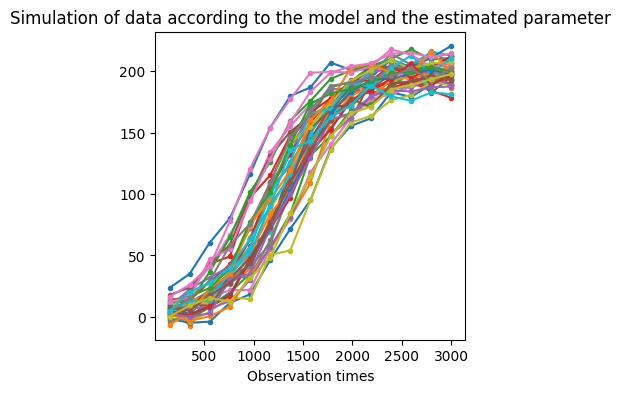

In [180]:
p_estim = myModel.parametrization.reals1d_to_params(
    jnp.array([r.theta_reals1d[-1] for r in res]).mean(axis=0)
)
obs, _ = myModel.sample(p_estim, jrd.PRNGKey(0))

ax = sdgplt.ax(4, 4)
_ = ax.plot(obs["mem_obs_time"].T, obs["Y"].T, ".-")
ax.set_title("Simulation of data according to the model and the estimated parameter")
ax.set_xlabel("Observation times")

[(<Figure size 400x400 with 2 Axes>,
  array([<Axes: title={'center': 'MCMC of phi1'}, ylabel='Chain'>,
         <Axes: xlabel='Iteration', ylabel='Acceptance rate'>], dtype=object)),
 (<Figure size 400x400 with 2 Axes>,
  array([<Axes: title={'center': 'MCMC of phi2'}, ylabel='Chain'>,
         <Axes: xlabel='Iteration', ylabel='Acceptance rate'>], dtype=object))]

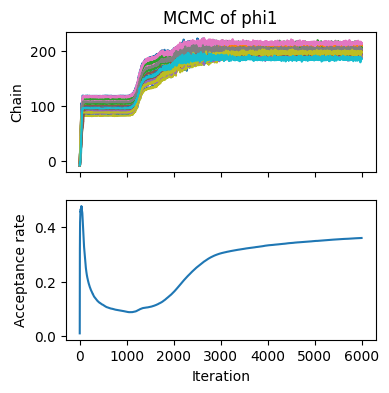

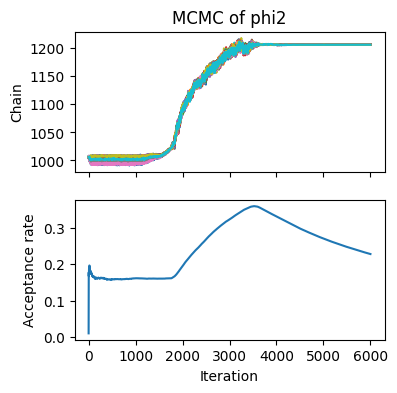

In [200]:
sdgplt.plot_mcmc(algo)